<a href="https://colab.research.google.com/github/ZiminPark/recsim/blob/master/recsim/colab/RecSim_Developing_an_Environment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Developing an Environment

<p align="center"><img width="70%" src="https://github.com/google-research/recsim/blob/master/recsim/colab/figures/simulator.png?raw=true" /></p>

- 위 그림에서 초록색과 파란색 블락들이 RecSim 환경에서 구현해야하는 부분들이다.
- 이번 노트에서는 각 블럭의 역할과 어떻게 얘네들이 조합되는지 살펴보자.
- 이 과정에서 end-to-end로 구현해볼 것이다.

# Overview

RecSim simulation의 한 step은 다음처럼 요약될 수 있다.


1.   document는 *D* documents를 추천시스템에 제공. 스텝마다 다를 수도 있고 시뮬레이션 기간동안 고정될 수도 있다. D는 a list of features 로 표현된다. fully observable 상황에서는 추천시스템이 유저의 state와 선택에 영향을 미치는 모든 feature를 볼 수 있다. 그러나 일반적으로 그럴 필요는 없을 것이다. <br>

2.   Agent는 *D* documents와 마지막 추천에 대한 반응을 관측할 수 있다. 그리고 다시 *k* documents를 유저에게 추천한다. 순서는 유저 선택이나 state에 영향을 줄 수도 있고 아닐 수도 있다. 당신의 goal에 따라 다르다.<br>

3. 유저는 추천된 documents목록을 보고 선택하거나 안 할 수도 있다. 이는 관측 유저의 반응과 latent space에 대한 반응을 만들어낸다. 보통 유저의 state가 fully 드러나지는 않는다.<br>

위의 그림을 자세히 보면 정보가 acyclic함을 알 수 잇다. 즉 RecSim은 dynamic Bayesian network (DBN)이다. Box는 conditional probability distributions을 나타낸다. 이제 간단한 시뮬레이션 문제를 정의하고 실행할 것이다.

#Simulation Scenario: Choc vs. Kale

다음 상황을 생각해보자. Corpus의 요소들이 얼마나 영양가있는가로 결정된다. 영양가있는 아이템은 `kale`로 후회스러운 아이템은 `chocalate`로 부르자. 후회스러운 documents는 유저들이 많이 반응하지만 장기적으로는 유저의 만족도를 하락시킨다. 반대로 영양가 있는 아이템은 반응은 적지만 장기적으로는 높은 만족감을 만든다. 우리는 document 특징을 [0,1] 사이의 연속적인 feature로 모델할 거고 Kaleness 척도로 부르자. 1이 영양가 높은 거고 0이 후회스러운 것이다.

유저의 latent state는 *satisfaction* 1차원 피쳐로 정의된다. "kaley"를 섭취하면 satisfaction이 증가하고 
"chocolate"을 섭취하면 감소한다. 유저가 아이템을 소비하면 engagement 척도를 emit한다. 이 수치는 유저의 만족도에 비례하고 kaleness에 반비례한다.

이제 우리의 목표는 장기적으로 유저의 engage가 높아지는 chocolatey and kaley 아이템 사이의 적절한 조합을 찾는 것이다.

다양한 요소들에 대한 함수 형태를 살펴보자.

In [ ]:
!pip install --upgrade --no-cache-dir recsim

In [22]:
import numpy as np
from gym import spaces
import matplotlib.pyplot as plt
from scipy import stats

In [23]:
from recsim import document
from recsim import user
from recsim.choice_model import MultinomialLogitChoiceModel
from recsim.simulator import environment
from recsim.simulator import recsim_gym

#A Document Model

Document 클래스는 `recsim.document.AbstractDocument`를 상속받아 쓴다. 

base class를 상속받으면 `observation_space() `static method를 구현해야 한다. OpenAI gym의 `space` 타입으로 document observable features 형식을 반환한다. 그리고 realization of said space을 반환하는 `create_observation` 함수도 만들어야 한다.
각각의 document는 unique integer ID를 가져야한다.

우리의 경우 documents가 하나의 피쳐(kaleness value)만 갖는다.

In [24]:
class LTSDocument(document.AbstractDocument):
  def __init__(self, doc_id, kaleness):
    self.kaleness = kaleness
    # doc_id is an integer representing the unique ID of this document
    super(LTSDocument, self).__init__(doc_id)

  def create_observation(self):
    return np.array([self.kaleness])

  @staticmethod
  def observation_space():
    return spaces.Box(shape=(1,), dtype=np.float32, low=0.0, high=1.0)
  
  def __str__(self):
    return f"Document {self._doc_id} with kaleness {self.kaleness}."

이제 document sampler를 만들어 보자. 
`document.AbstractDocumentSampler`를 상속 받아 쓰고 `sample_document()`함수가 구현되어야 한다. 특정 분포에서 샘플한 `document`를 반환해야 한다.
우리의 경우 uniform distribution에서 추출할 것이다.

In [25]:
class LTSDocumentSampler(document.AbstractDocumentSampler):
  def __init__(self, doc_ctor=LTSDocument, **kwargs):
    super(LTSDocumentSampler, self).__init__(doc_ctor, **kwargs)
    self._doc_count = 0

  def sample_document(self):
    doc_features = {}
    doc_features['doc_id'] = self._doc_count
    doc_features['kaleness'] = self._rng.random_sample()
    self._doc_count += 1
    return self._doc_ctor(**doc_features)

With this we can now simulate documents.

In [26]:
sampler = LTSDocumentSampler()
for i in range(5): print(sampler.sample_document())
d = sampler.sample_document()
print("Documents have observation space:", d.observation_space(), "\n"
      "An example realization is: ", d.create_observation())

Document 0 with kaleness 0.5488135039273248.
Document 1 with kaleness 0.7151893663724195.
Document 2 with kaleness 0.6027633760716439.
Document 3 with kaleness 0.5448831829968969.
Document 4 with kaleness 0.4236547993389047.
Documents have observation space: Box(0.0, 1.0, (1,), float32) 
An example realization is:  [0.64589411]


RecSim에서는 직접 documents를 샘플하지 않고 시뮬레이터가 한다. 그래서 필요한 argument이다.

#A User Model

이제 유저 모델을 만들어 보자. 구성요소는 다음과 같다.
* a user state,
* a user sampler (a distribution over the starting state of users), 
* a user state transition model, and
* a user response.

튜토리얼에서 사용할 모델은 다음과 같다:
* 각각의 유저는 called net kale exposure($\text{nke}_t$)와 만족도($\text{sat}_t$)를 갖고 있다. 둘은 satisfaction이 unbounded되어 있음을 표현하기 위해 logistic function으로 엮여있다. 즉, $$\text{sat}_t = \sigma(\tau\cdot\text{nke}_t),$$ 이고 $\tau$는 유저 고유의 민감도 파라미터이다. Satisfaction과 net kale exposure는 bijectively 서로 얽혀있다. 그래서 state를 추적하기 위해서는 한 가지만 저장하면 된다.<br>

* slate $S$가 주어졌을 때 유저는 multinomial logit choice model을 기반으로 아이템을 선정한다. 이때 items' chocolateness를 피쳐로 쓴다. $p(\text{user chooses }d_i \text{ from slate }S) \sim e^{1-\mathrm{kaleness}(d_i)}$ 왜냐하면 초코리키한 걸 더 clicky하기 때문이다.

* 유저가 document를 선택하면 net kale exposure은 다음처럼 변한다. $$\text{nke}_{t+1} = \beta \cdot \text{nke}_t + 2(k_d - 1/2) + {\cal N}(0, \eta),$$ 
$\beta$는 유저 고유의 forgetting factor이고 $k_d$는 선택한 다큐의 kaleness, $\eta$는 노이즈 분포의 표준편차다.

* 마지막으로 유저가 선택한 콘텐츠를 $s_d$ 동안 사용했다. $s_d$는 $$s_d\sim\log{\cal N}(k_d\mu_k + (1-k_d)\mu_c, k_d\sigma_k + (1-k_d)\sigma_c),$$ 에서 만들어졌다. 즉, log-normal distribution이고 파라미터로는 pure kale response $(\mu_k, \sigma_k)$와 pure choc response $(\mu_c, \sigma_c)$ 사이를 linearly interpolating값으로 사용한다.

유저의 state는 $(\text{sat}, \tau, \beta, \eta, \mu_k, \sigma_k, \mu_c, \sigma_c).$로 결정된다. satisfaction 변수만 state중 변하는 값인 반면 다른 파라미터는 static하다.


## User state and user sampler 

documents와 비슷하게 이런 파라미터의 container역할을 하는 user state class를 구현할 것이다. `AbstractDocument`와 비슷하게 `AbstractUserState`는 `observation_space()` 와 `create_observations()`을 구현해야 한다. 이런 애들은 유저 state의 부분적인(또는 모든) 정보를 매 Iter마다 agent에게 넘겨준다.

시간 제한을 둘 수 있지만 요기서는 하지 않겠다.

마지막으로 `score_document method`를 구현한다. document와 non-negative 실수를 대응하는 함수이다. 이 함수의 의의는 금방 알게될 것이다.

In [27]:
class LTSUserState(user.AbstractUserState):
  def __init__(self, memory_discount, sensitivity, innovation_stddev,
               choc_mean, choc_stddev, kale_mean, kale_stddev,
               net_kaleness_exposure, time_budget, observation_noise_stddev=0.1
              ):
    ## Transition model parameters
    ##############################
    self.memory_discount = memory_discount
    self.sensitivity = sensitivity
    self.innovation_stddev = innovation_stddev

    ## Engagement parameters
    self.choc_mean = choc_mean
    self.choc_stddev = choc_stddev
    self.kale_mean = kale_mean
    self.kale_stddev = kale_stddev

    ## State variables
    ##############################
    self.net_kaleness_exposure = net_kaleness_exposure
    self.satisfaction = 1 / (1 + np.exp(-sensitivity * net_kaleness_exposure))
    self.time_budget = time_budget

    # Noise
    self._observation_noise = observation_noise_stddev

  def create_observation(self):
    """User's state is not observable."""
    clip_low, clip_high = (-1.0 / (1.0 * self._observation_noise),
                           1.0 / (1.0 * self._observation_noise))
    noise = stats.truncnorm( 
        clip_low, clip_high, loc=0.0, scale=self._observation_noise).rvs()
    noisy_sat = self.satisfaction + noise
    return np.array([noisy_sat,])

  @staticmethod
  def observation_space():
    return spaces.Box(shape=(1,), dtype=np.float32, low=-2.0, high=2.0)
  
  # scoring function for use in the choice model -- the user is more likely to
  # click on more chocolatey content.
  def score_document(self, doc_obs):
    return 1 - doc_obs

- Document Model처럼 매 세션마다 starting 유저를 정의할 state sampler가 필요하다. 

- 이번 튜토리얼에서는 $\text{nke}_0$를 샘플하고 나머지 파라미터는 같게 한다. 즉 우리는 다른 수준의 만족도를 갖는 같은 유저들을 다루는 것이다. 당연히 다른 파라미터를 갖는 다양한 랜덤 유저로 확장할 수도 있다.

- $\eta = 0$이면, $\text{nke}$ 값은 $\left[-\frac{1}{1-\beta}, \ldots, \frac{1}{1-\beta} \right]$에 항상 bound된다. 시작 분포는 이 구간에서 uniformly 샘플한다.
샘플링 코드는 `sample_user()`에 구현한다. `user.AbstractUserSampler` base class의 메서드이다.

In [28]:
class LTSStaticUserSampler(user.AbstractUserSampler):
  _state_parameters = None

  def __init__(self,
               user_ctor=LTSUserState,
               memory_discount=0.9,
               sensitivity=0.01,
               innovation_stddev=0.05,
               choc_mean=5.0,
               choc_stddev=1.0,
               kale_mean=4.0,
               kale_stddev=1.0,
               time_budget=60,
               **kwargs):
    self._state_parameters = {'memory_discount': memory_discount,
                              'sensitivity': sensitivity,
                              'innovation_stddev': innovation_stddev,
                              'choc_mean': choc_mean,
                              'choc_stddev': choc_stddev,
                              'kale_mean': kale_mean,
                              'kale_stddev': kale_stddev,
                              'time_budget': time_budget
                             }
    super(LTSStaticUserSampler, self).__init__(user_ctor, **kwargs)

  def sample_user(self):
    starting_nke = ((self._rng.random_sample() - .5) *
                    (1 / (1.0 - self._state_parameters['memory_discount'])))
    self._state_parameters['net_kaleness_exposure'] = starting_nke
    return self._user_ctor(**self._state_parameters)


Let's try this out!

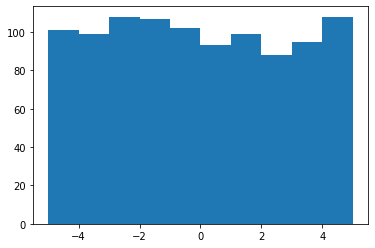

In [29]:
sampler = LTSStaticUserSampler()
starting_nke = []
for i in range(1000):
  sampled_user = sampler.sample_user()
  starting_nke.append(sampled_user.net_kaleness_exposure)
_ = plt.hist(starting_nke)

## Response model

- 다음으로 해야하는 건 `user response` class다. RecSim은 매 추천에 대해 반응을 생성한다. 
- 응답에 대한 내용은 agent가 추천에서 document-specific feedback을 볼 것이다. (non-document specific feedback은 `LTSUserState.create_observation`에서 생성된다.)

In [30]:
class LTSResponse(user.AbstractResponse):
  # The maximum degree of engagement.
  MAX_ENGAGEMENT_MAGNITUDE = 100.0

  def __init__(self, clicked=False, engagement=0.0):
    self.clicked = clicked
    self.engagement = engagement

  def create_observation(self):
    return {'click': int(self.clicked), 'engagement': np.array(self.engagement)}

  @classmethod
  def response_space(cls):
    # `engagement` feature range is [0, MAX_ENGAGEMENT_MAGNITUDE]
    return spaces.Dict({
        'click':
            spaces.Discrete(2),
        'engagement':
            spaces.Box(
                low=0.0,
                high=cls.MAX_ENGAGEMENT_MAGNITUDE,
                shape=tuple(),
                dtype=np.float32)
    })

##User model

이제 실제 유저의 행동을 구체화 해보자. RecSim user model은  `recsim.user.AbstractUserModel`을 base로 하고
* user state을 유지하고,
* 추천의 결과로 user state를 evolving하고
* slate 추천의 결과에 대한 반응을 생성한다.

끝에 가서는 user model은 `update_state()`와 `simulate_response()`을 구현해야 하고 세션의 끝을 알리는 `is_terminal`도 있어야 한다. self.time_budget*을 매 step 호출마다 줄이면 된다. 먼저 함수 단위로 나눠서 살펴보고 나중에 class로 합치자.

- init은 간단하다. response_model, user sampler, slate size을 base 모델인 AbstractUserModel의 생성자로 넘겨준다.

- 다른 환경을 Exploring하면서 user model의 \_\_init\_\_ 함수가 simulation을 configuring할 때 많은 flexibility를 제공한다는 것을 볼 수 있다. 그러나 지금은 기본에 집중하자.

In [31]:
def user_init(self,
              slate_size,
              seed=0):

  super(LTSUserModel,
        self).__init__(LTSResponse,
                       LTSStaticUserSampler(LTSUserState,
                                            seed=seed), slate_size)
  self.choice_model = MultinomialLogitChoiceModel({})

`simulate_response()`는 slate 추천을 받고 그에 대한 반응을 리턴한다.



In [33]:
def simulate_response(self, slate_documents):
  # List of empty responses
  responses = [self._response_model_ctor() for _ in slate_documents]
  # Get click from of choice model.
  self.choice_model.score_documents(
    self._user_state, [doc.create_observation() for doc in slate_documents])
  scores = self.choice_model.scores
  selected_index = self.choice_model.choose_item()
  # Populate clicked item.
  self._generate_response(slate_documents[selected_index],
                          responses[selected_index])
  return responses

def generate_response(self, doc, response):
  response.clicked = True
  # linear interpolation between choc and kale.
  engagement_loc = (doc.kaleness * self._user_state.choc_mean
                    + (1 - doc.kaleness) * self._user_state.kale_mean)
  engagement_loc *= self._user_state.satisfaction
  engagement_scale = (doc.kaleness * self._user_state.choc_stddev
                      + ((1 - doc.kaleness)
                          * self._user_state.kale_stddev))
  log_engagement = np.random.normal(loc=engagement_loc,
                                    scale=engagement_scale)
  response.engagement = np.exp(log_engagement)

`update_state()`메서드는 state transition kernel 을 구현해야 한다. 인풋으로 slate와 유저의 선택을 받는다. in-place로 바뀌어서 return은 없다.

In [34]:
def update_state(self, slate_documents, responses):
  for doc, response in zip(slate_documents, responses):
    if response.clicked:
      innovation = np.random.normal(scale=self._user_state.innovation_stddev)
      net_kaleness_exposure = (self._user_state.memory_discount
                                * self._user_state.net_kaleness_exposure
                                - 2.0 * (doc.kaleness - 0.5)
                                + innovation
                              )
      self._user_state.net_kaleness_exposure = net_kaleness_exposure
      satisfaction = 1 / (1.0 + np.exp(-self._user_state.sensitivity
                                        * net_kaleness_exposure)
                          )
      self._user_state.satisfaction = satisfaction
      self._user_state.time_budget -= 1
      return

budget이 0이 되면 멈춘다.

In [35]:
def is_terminal(self):
  """Returns a boolean indicating if the session is over."""
  return self._user_state.time_budget <= 0

We have all the components to instantiate a user model, so let's wrap them up in a class.

In [36]:
LTSUserModel = type("LTSUserModel", (user.AbstractUserModel,),
                    {"__init__": user_init,
                     "is_terminal": is_terminal,
                     "update_state": update_state,
                     "simulate_response": simulate_response,
                     "_generate_response": generate_response})

In [37]:
 slate_size = 3
 num_candidates = 10
 ltsenv = environment.Environment(
            LTSUserModel(slate_size),
            LTSDocumentSampler(),
            num_candidates,
            slate_size,
            resample_documents=True)


## Recap
Before we conclude, let's take a second to recap everything we've done so far. The diagram below maps all the classes we've implemented/imported from RecSim to the functional diagram of RecSim.
![RecSim implementation](https://github.com/google-research/recsim/blob/master/recsim/colab/figures/simulator_implemented.png?raw=true)



## Interacting with an agent

- 이제 환경에 관한 건 전부 구현했다. 
- agent를 학습/ 평가를 위해 먼저 반응을 실수로 대응시키는 reward function을 정하자. 
- 클릭한 documents의 engagement을 최대화하는 문제를 가정하자.

In [38]:
def clicked_engagement_reward(responses):
  reward = 0.0
  for response in responses:
    if response.clicked:
      reward += response.engagement
  return reward

이제 step단위로 익숙한 OpenAI gym wrapper를 사용할 것이다.

In [39]:
lts_gym_env = recsim_gym.RecSimGymEnv(ltsenv, clicked_engagement_reward)

In [41]:
observation_0 = lts_gym_env.reset()
print('Observation 0')
print('Available documents')
doc_strings = ['doc_id ' + key + " kaleness " + str(value) for key, value
               in observation_0['doc'].items()]
print('\n'.join(doc_strings))
print('Noisy user state observation')
print(observation_0['user'])

Observation 0
Available documents
doc_id 30 kaleness [0.26455561]
doc_id 31 kaleness [0.77423369]
doc_id 32 kaleness [0.45615033]
doc_id 33 kaleness [0.56843395]
doc_id 34 kaleness [0.0187898]
doc_id 35 kaleness [0.6176355]
doc_id 36 kaleness [0.61209572]
doc_id 37 kaleness [0.616934]
doc_id 38 kaleness [0.94374808]
doc_id 39 kaleness [0.6818203]
Noisy user state observation
[0.64081684]


In [42]:
# Agent recommends the first three documents.
recommendation_slate_0 = [0, 1, 2]
observation_1, reward, done, _ = lts_gym_env.step(recommendation_slate_0)
print('Observation 1')
print('Available documents')
doc_strings = ['doc_id ' + key + " kaleness " + str(value) for key, value
               in observation_1['doc'].items()]
print('\n'.join(doc_strings))
rsp_strings = [str(response) for response in observation_1['response']]
print('User responses to documents in the slate')
print('\n'.join(rsp_strings))
print('Noisy user state observation')
print(observation_1['user'])

Observation 1
Available documents
doc_id 40 kaleness [0.3595079]
doc_id 41 kaleness [0.43703195]
doc_id 42 kaleness [0.6976312]
doc_id 43 kaleness [0.06022547]
doc_id 44 kaleness [0.66676672]
doc_id 45 kaleness [0.67063787]
doc_id 46 kaleness [0.21038256]
doc_id 47 kaleness [0.1289263]
doc_id 48 kaleness [0.31542835]
doc_id 49 kaleness [0.36371077]
User responses to documents in the slate
{'click': 1, 'engagement': array(3.80960019)}
{'click': 0, 'engagement': array(0.)}
{'click': 0, 'engagement': array(0.)}
Noisy user state observation
[0.52654626]
